Creating custom reports and machine learning models with pandas can be cumbersome with limited hardware resources (memory and CPU). Financial constraints can make spawning cloud instances to side-step this issue a problem, while adding the complexity of libraries such as Apache Spark isn't worth the trouble and staggers data exploration. **How can we keep the simplicity and power of pandas, while extending it to be out-of-core and parallel?**

Enter [Dask](https://dask.pydata.org/en/latest/): a flexible parallel computing library for analytic computing. With it we will create a linear regression model to predict [read time in Medium posts](https://help.medium.com/hc/en-us/articles/214991667-Read-time) using a Kaggle dataset, while comparing the equivalent implementation with pandas.

### 1. Kaggle data

We will be using the official kaggle api to automate our data fetching process.

1. Log on to kaggle and enter the [How good is your Medium article?](https://www.kaggle.com/c/how-good-is-your-medium-article) competition.
2. Configure the official kaggle api [following these steps](https://github.com/Kaggle/kaggle-api).

For this tutorial we will need only 1 file.
```bash
kaggle competitions download -c how-good-is-your-medium-article -f train.json.gz

```

The reason for decompressing will become clear later.

```bash
gunzip -k ~/.kaggle/competitions/how-good-is-your-medium-article/train.json.gz
```

This sample file will help us speed up the analysis.

```bash
head -n5 ~/.kaggle/competitions/how-good-is-your-medium-article/train.json > \
         ~/.kaggle/competitions/how-good-is-your-medium-article/train-sample.json
```

### 2. Exploration.

Despite the extension being json our data is stored as [jsonl](http://jsonlines.org/). This means that each line of `train.json` is a valid json file.

```bash
head -n1 ~/.kaggle/competitions/how-good-is-your-medium-article/train.json | jq 'del(.content)'
```
```json
{
  "_id": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f",
  "_timestamp": 1520035195.282891,
  "_spider": "medium",
  "url": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f",
  "domain": "medium.com",
  "published": {
    "$date": "2012-08-13T22:54:53.510Z"
  },
  "title": "Medium Terms of Service – Medium Policy – Medium",
  "author": {
    "name": null,
    "url": "https://medium.com/@Medium",
    "twitter": "@Medium"
  },
  "image_url": null,
  "tags": [],
  "link_tags": {
    "canonical": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f",
    "publisher": "https://plus.google.com/103654360130207659246",
    "author": "https://medium.com/@Medium",
    "search": "/osd.xml",
    "alternate": "android-app://com.medium.reader/https/medium.com/p/9db0094a1e0f",
    "stylesheet": "https://cdn-static-1.medium.com/_/fp/css/main-branding-base.Ch8g7KPCoGXbtKfJaVXo_w.css",
    "icon": "https://cdn-static-1.medium.com/_/fp/icons/favicon-rebrand-medium.3Y6xpZ-0FSdWDnPM3hSBIA.ico",
    "apple-touch-icon": "https://cdn-images-1.medium.com/fit/c/120/120/1*6_fgYnisCa9V21mymySIvA.png",
    "mask-icon": "https://cdn-static-1.medium.com/_/fp/icons/monogram-mask.KPLCSFEZviQN0jQ7veN2RQ.svg"
  },
  "meta_tags": {
    "viewport": "width=device-width, initial-scale=1",
    "title": "Medium Terms of Service – Medium Policy – Medium",
    "referrer": "unsafe-url",
    "description": "These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”). By using…",
    "theme-color": "#000000",
    "og:title": "Medium Terms of Service – Medium Policy – Medium",
    "og:url": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f",
    "fb:app_id": "542599432471018",
    "og:description": "These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”). By using…",
    "twitter:description": "These Terms of Service (“Terms”) are a contract between you and A Medium Corporation. They govern your use of Medium’s sites, services, mobile apps, products, and content (“Services”). By using…",
    "author": "Medium",
    "og:type": "article",
    "twitter:card": "summary",
    "article:publisher": "https://www.facebook.com/medium",
    "article:author": "https://medium.com/@Medium",
    "robots": "index, follow",
    "article:published_time": "2012-08-13T22:54:53.510Z",
    "twitter:creator": "@Medium",
    "twitter:site": "@Medium",
    "og:site_name": "Medium",
    "twitter:label1": "Reading time",
    "twitter:data1": "5 min read",
    "twitter:app:name:iphone": "Medium",
    "twitter:app:id:iphone": "828256236",
    "twitter:app:url:iphone": "medium://p/9db0094a1e0f",
    "al:ios:app_name": "Medium",
    "al:ios:app_store_id": "828256236",
    "al:android:package": "com.medium.reader",
    "al:android:app_name": "Medium",
    "al:ios:url": "medium://p/9db0094a1e0f",
    "al:android:url": "medium://p/9db0094a1e0f",
    "al:web:url": "https://medium.com/policy/medium-terms-of-service-9db0094a1e0f"
  }
}
```

I've ommited the `content` field due to it's huge verbosity. Our problem requires that we use the fields `published.$date` and `meta_tags.twitter:data`.

```bash
head -n10 train.json | jq '[.published["$date"], .meta_tags["twitter:data1"]] | @csv' -r
```
```
"2012-08-13T22:54:53.510Z","5 min read"
"2015-08-03T07:44:50.331Z","7 min read"
"2017-02-05T13:08:17.410Z","2 min read"
"2017-05-06T08:16:30.776Z","3 min read"
"2017-06-04T14:46:25.772Z","4 min read"
"2017-04-02T16:21:15.171Z","7 min read"
"2016-08-15T04:16:02.103Z","12 min read"
"2015-01-14T21:31:07.568Z","5 min read"
"2014-02-11T04:11:54.771Z","4 min read"
"2015-10-25T02:58:05.551Z","8 min read"
```

### 3. Building the time-series: The good, the bad and the ugly.

In [1]:
%matplotlib inline

In [2]:
import json
import pandas as pd
import numpy as np
import os
import dask.bag as db

from toolz.curried import get
from typing import Dict

HOME = os.environ['HOME']
KAGGLE_DATASET_HOME = '.kaggle/competitions/how-good-is-your-medium-article/'
train_file = f'{HOME}/{KAGGLE_DATASET_HOME}/train.json'
train_sample_file = f'{HOME}/{KAGGLE_DATASET_HOME}/train-sample.json'
MEGABYTES = 1024**2

#### The Ugly

`read_json` loads each json as a record, parsing each object beforehand.

In [3]:
(
    pd
    .read_json(train_sample_file, lines=True)
    [['published', 'meta_tags']]
)

,published,meta_tags
0,{'$date': '2012-08-13T22:54:53.510Z'},"{'viewport': 'width=device-width, initial-scal..."
1,{'$date': '2015-08-03T07:44:50.331Z'},"{'viewport': 'width=device-width, initial-scal..."
2,{'$date': '2017-02-05T13:08:17.410Z'},"{'viewport': 'width=device-width, initial-scal..."
3,{'$date': '2017-05-06T08:16:30.776Z'},"{'viewport': 'width=device-width, initial-scal..."
4,{'$date': '2017-06-04T14:46:25.772Z'},"{'viewport': 'width=device-width, initial-scal..."


Both columns have object values. Our fields of interest can be extracted and assigned to a new column using the `assign` function.

In [4]:
(
    _
    .assign(
        published_timestamp = lambda df: df['published'].apply(dict.get, args=('$date',)),
        read_time = lambda df: df['meta_tags'].apply(dict.get, args=('twitter:data1',)),
    )
)

,published,meta_tags,published_timestamp,read_time
0,{'$date': '2012-08-13T22:54:53.510Z'},"{'viewport': 'width=device-width, initial-scal...",2012-08-13T22:54:53.510Z,5 min read
1,{'$date': '2015-08-03T07:44:50.331Z'},"{'viewport': 'width=device-width, initial-scal...",2015-08-03T07:44:50.331Z,7 min read
2,{'$date': '2017-02-05T13:08:17.410Z'},"{'viewport': 'width=device-width, initial-scal...",2017-02-05T13:08:17.410Z,2 min read
3,{'$date': '2017-05-06T08:16:30.776Z'},"{'viewport': 'width=device-width, initial-scal...",2017-05-06T08:16:30.776Z,3 min read
4,{'$date': '2017-06-04T14:46:25.772Z'},"{'viewport': 'width=device-width, initial-scal...",2017-06-04T14:46:25.772Z,4 min read


Extracting the time value in `read_time` can be done with `pd.Series.str` processing methods. When called, the equivalent function is applied to each value, hence `.str.split(' ').str[0]` is equivalent to `'5 min read'.split(' ')[0]`.

`astype` casts our columns to the necessary dtypes.

In [5]:
(
    _
    .assign(read_time = lambda df: df['read_time'].str.split(' ').str[0])
    .astype({
        'read_time': int,
        'published_timestamp': 'datetime64[ns]'
    })
    .set_index('published_timestamp')
    ['read_time']
    .to_frame()
)

,read_time
published_timestamp,
2012-08-13 22:54:53.510,5
2015-08-03 07:44:50.331,7
2017-02-05 13:08:17.410,2
2017-05-06 08:16:30.776,3
2017-06-04 14:46:25.772,4


#### The Bad

The issue with The Ugly solution is that `read_json` loads the entire dataset into memory before slicing the necessary columns (`published` and `meta_tags`). Pre-processing our data with pure python consumes less RAM.

In [6]:
def make_datum(x):
    return {
        'published_timestamp': x['published']['$date'],
        'read_time': x['meta_tags']['twitter:data1']
    }

with open(train_sample_file, 'r') as f:    
    bad_df = pd.DataFrame([make_datum(json.loads(x)) for x in f])

In [7]:
bad_df

,published_timestamp,read_time
0,2012-08-13T22:54:53.510Z,5 min read
1,2015-08-03T07:44:50.331Z,7 min read
2,2017-02-05T13:08:17.410Z,2 min read
3,2017-05-06T08:16:30.776Z,3 min read
4,2017-06-04T14:46:25.772Z,4 min read


In [8]:
(
    _
    .assign(read_time = lambda x: x['read_time'].str.split(' ').str[0])
    .astype({
        'published_timestamp': 'datetime64[ns]',
        'read_time': int
    })
    .set_index('published_timestamp')
    ['read_time']
    .to_frame()
)

,read_time
published_timestamp,
2012-08-13 22:54:53.510,5
2015-08-03 07:44:50.331,7
2017-02-05 13:08:17.410,2
2017-05-06 08:16:30.776,3
2017-06-04 14:46:25.772,4


#### The Good

Dask allows us to build lazy computational graphs. For example, `db.read_text` will return a reference to each line of our jsonl file. After, `.map` applies `json.loads` to each line and `.to_dataframe` casts the data to a dask DataFrame preserving **only** the columns we explicitly tell it (in this case `published` and `meta_tags`). The rest of the code proceeds analogously with the previous implementations. The only difference is that **dask won't actually process anything until we call the `.compute` method**, returning a pandas DataFrame. In other words, a dask DataFrame is a lazy version of a pandas DataFrame. The same is true for series.

Notice how we pass the `blocksize` parameter as 100 MB. Since our file has 2 GB, dask creates 20 independent partitions. Most methods that are called (like `.map` and `.assign`) run in parallel, potentially speeding up computation significantly. Memory is also spared, since we only load the fields we need.

In [9]:
dag = (
    db
    .read_text(train_file, blocksize=100*MEGABYTES)
    .map(json.loads)
    .to_dataframe({
        'published': object,
        'meta_tags': object
    })
    .assign(
        published_timestamp=lambda df: df['published'].apply(get('$date')),
        read_time=lambda df: df['meta_tags'].apply(get('twitter:data1')).str.split(' ').str[0],
    )
    .astype({
        'published_timestamp': 'datetime64[ns]',
        'read_time': int
    })
    [['published_timestamp', 'read_time']]
)

dag

,published_timestamp,read_time
npartitions=20,,
,datetime64[ns],int64
,...,...
...,...,...
,...,...
,...,...


Other methods like `.head(N)` also force the dataframe to be computed. Since this call needs only the first `N` rows, dask will partially solve the graph such that only those are processed.

In [10]:
(
    _
    .head()
    .set_index('published_timestamp')
)

,read_time
published_timestamp,
2012-08-13 22:54:53.510,5
2015-08-03 07:44:50.331,7
2017-02-05 13:08:17.410,2
2017-05-06 08:16:30.776,3
2017-06-04 14:46:25.772,4


# 4. Prediction

Here we will implement simple linear regression for a single variable with intercept: $y = \alpha + \beta x$, the closed form solution is: 

$$\beta = \frac{cov(x,y)}{var(x)}$$
$$\alpha = \bar{y} - \beta \bar{x}$$

where $\bar{y}$ and $\bar{x}$ are the average values of the vectors $y$ and $x$, respectively.


In [11]:
def linear_regression(y: np.array, x: np.array, prefix='') -> Dict[str, float]:
    M = np.cov(x, y)
    beta = M[0,1]/M[0,0]
    alpha = y.mean() - beta*x.mean()
    return {
        prefix + 'alpha': alpha, 
        prefix + 'beta': beta
    }

In [12]:
df = (
    dag
    .compute()
    .set_index('published_timestamp')
    ['2015':]
    ['read_time']
    .groupby(lambda i: pd.to_datetime(i.strftime('%Y/%m')))
    .agg(['mean', 'sum'])
)

df.head()

,mean,sum
2015-01-01,8.380952,4928
2015-02-01,7.887564,4630
2015-03-01,7.907840,5749
2015-04-01,7.667149,5298
2015-05-01,8.307506,6862


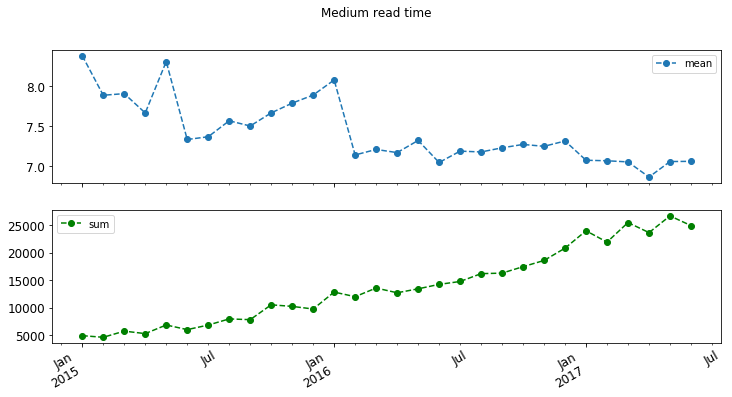

In [13]:
df.plot(
    style=['o--', 'og--'], figsize=(12,6),
    subplots=True, title='Medium read time', fontsize=12
);

In [17]:
df_pred = (
    df
    .assign(**linear_regression(df['mean'], df.index.asi8, prefix='mean_'))
    .assign(**linear_regression(df['sum'], df.index.asi8, prefix='sum_'))
    .assign(mean_pred = lambda z: z['mean_alpha'] + z['mean_beta']*z.index.asi8)
    .assign(sum_pred = lambda z: z['sum_alpha'] + z['sum_beta']*z.index.asi8)
)

df_pred[['mean_alpha', 'mean_beta', 'sum_alpha', 'sum_beta', 'mean_pred', 'sum_pred']].head()

,mean_alpha,mean_beta,sum_alpha,sum_beta,mean_pred,sum_pred
2015-01-01,27.130799,-1.351069e-17,-407905.660648,2.892460e-13,7.944669,2844.030846
2015-02-01,27.130799,-1.351069e-17,-407905.660648,2.892460e-13,7.908482,3618.747348
2015-03-01,27.130799,-1.351069e-17,-407905.660648,2.892460e-13,7.875797,4318.491286
2015-04-01,27.130799,-1.351069e-17,-407905.660648,2.892460e-13,7.839610,5093.207789
2015-05-01,27.130799,-1.351069e-17,-407905.660648,2.892460e-13,7.804590,5842.933436


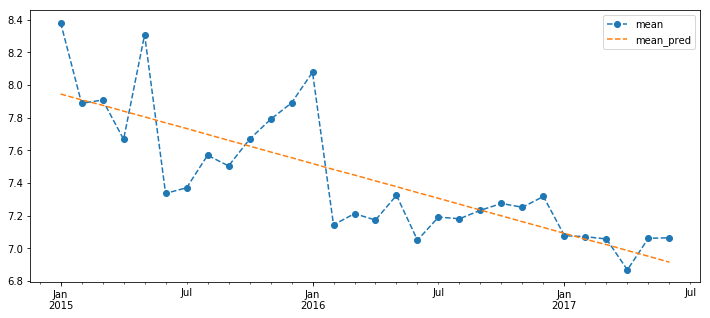

In [15]:
(
    df_pred
    [['mean', 'mean_pred']]
    .plot(figsize=(12,5), style=['o--', '--'])
);

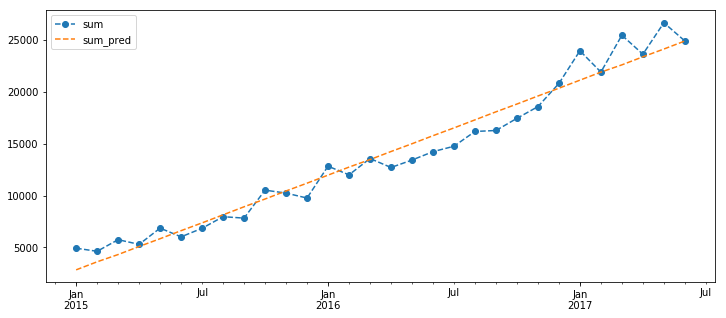

In [16]:
(
    df_pred
    [['sum', 'sum_pred']]
    .plot(figsize=(12,5), style=['o--', '--'])
);